## Skin Cancer Classificator

Este proyecto implementa un clasificador binario de cáncer de piel (benigno vs. maligno) basado en redes neuronales convolutivas (CNN) con PyTorch. Las imágenes pertenecen a un dataset de imágenes de Kaggle, las guardamos en una carpeta accesible, se redimensionan a 28×28 píxeles y se normalizan. El conjunto se divide de forma reproducible (semilla fija) en entrenamiento (80%) y prueba (20%), y se itera con `DataLoader` para un procesamiento por lotes eficiente.

La arquitectura `ConvNet` consta de tres bloques convolución-ReLU seguidos de max-pooling, que progresivamente reducen la resolución espacial hasta 3×3 y aumentan la profundidad de 3→16→32→64 canales. Tras aplanar, dos capas totalmente conectadas proyectan a 120 unidades y finalmente a 2 salidas (una por clase). El modelo se entrena durante 100 épocas con la función de pérdida de entropía cruzada y el optimizador Adam (tasa de aprendizaje 0.001), imprimiendo la pérdida media por época como señal de convergencia.

En la evaluación, las salidas se transforman en probabilidades con *softmax* y se aplica un umbral de decisión personalizado (0.15) sobre la probabilidad de la clase “maligno”. Este umbral deliberadamente bajo favorece la sensibilidad (recuperar la mayor parte de los casos malignos) a costa de la especificidad. Se calculan e informan exactitud, sensibilidad y especificidad, y se visualiza la matriz de confusión.


In [74]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [75]:
seed = 42
torch.manual_seed(seed)
g = torch.Generator().manual_seed(seed)

In [76]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [77]:
dataset = datasets.ImageFolder(root='./Images', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, generator=g)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, generator=g)

In [78]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 2)  # 2 clases

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [79]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1, Loss: 0.5120
Epoch 2, Loss: 0.4053
Epoch 3, Loss: 0.3763
Epoch 4, Loss: 0.3738
Epoch 5, Loss: 0.3496
Epoch 6, Loss: 0.3425
Epoch 7, Loss: 0.3446
Epoch 8, Loss: 0.3255
Epoch 9, Loss: 0.3129
Epoch 10, Loss: 0.3102
Epoch 11, Loss: 0.2929
Epoch 12, Loss: 0.2766
Epoch 13, Loss: 0.2729
Epoch 14, Loss: 0.2507
Epoch 15, Loss: 0.2462
Epoch 16, Loss: 0.2072
Epoch 17, Loss: 0.2074
Epoch 18, Loss: 0.2162
Epoch 19, Loss: 0.2047
Epoch 20, Loss: 0.1581
Epoch 21, Loss: 0.1395
Epoch 22, Loss: 0.1487
Epoch 23, Loss: 0.1114
Epoch 24, Loss: 0.0924
Epoch 25, Loss: 0.0864
Epoch 26, Loss: 0.1152
Epoch 27, Loss: 0.0685
Epoch 28, Loss: 0.0581
Epoch 29, Loss: 0.0467
Epoch 30, Loss: 0.0228
Epoch 31, Loss: 0.0194
Epoch 32, Loss: 0.0352
Epoch 33, Loss: 0.0212
Epoch 34, Loss: 0.0093
Epoch 35, Loss: 0.0115
Epoch 36, Loss: 0.1058
Epoch 37, Loss: 0.0575
Epoch 38, Loss: 0.0567
Epoch 39, Loss: 0.0325
Epoch 40, Loss: 0.0143
Epoch 41, Loss: 0.0056
Epoch 42, Loss: 0.0054
Epoch 43, Loss: 0.0029
Epoch 44, Loss: 0.00

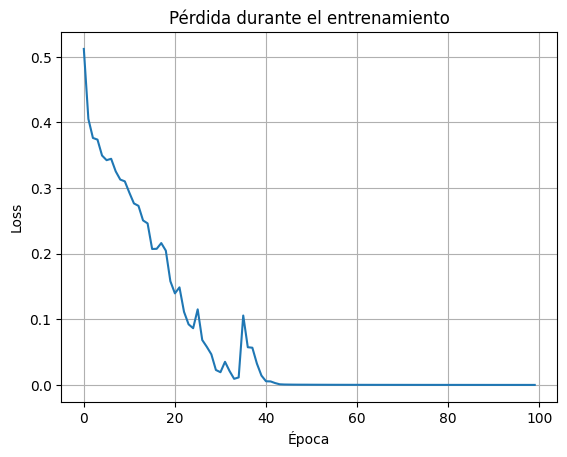

In [80]:
threshold = 0.001
epochs = 100
loss_history = []
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}')

plt.plot(loss_history)
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [81]:
correct, total = 0, 0
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1] 
        predicted = (probs >= threshold).long()

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

    accuracy = 100 * correct / total

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) 
    specificity = tn / (tn + fp)

    print(f'Accuracy: {accuracy:.2f}% | Sensibilidad: {sensitivity:.2f} | Especificidad: {specificity:.2f}')

Accuracy: 84.70% | Sensibilidad: 0.92 | Especificidad: 0.79


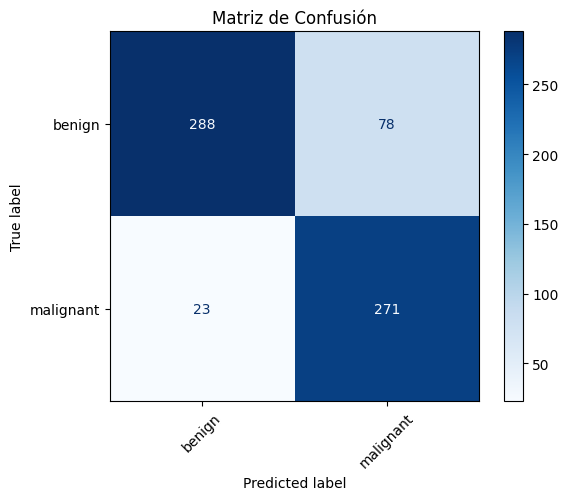

In [82]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()